In [1]:
import os, sys
project_dir = os.path.join(os.getcwd(),'..')
if project_dir not in sys.path:
    sys.path.append(project_dir)

sparse_dir = os.path.join(project_dir, 'modules/Sparse')
if sparse_dir not in sys.path:
    sys.path.append(sparse_dir)

medmnist_dir = os.path.join(project_dir, 'modules/MedMNIST')
if medmnist_dir not in sys.path:
    sys.path.append(medmnist_dir)

from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

In [2]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v2.0.2 @ https://github.com/MedMNIST/MedMNIST/


In [30]:
# data_flag = 'pathmnist'
data_flag = 'breastmnist'
download = True

NUM_EPOCHS = 10
BATCH_SIZE = 32
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [31]:
# preprocessing
from PIL import Image
data_transform = transforms.Compose([
    transforms.Resize(32, Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: /home/abian/.medmnist/breastmnist.npz
Using downloaded and verified file: /home/abian/.medmnist/breastmnist.npz
Using downloaded and verified file: /home/abian/.medmnist/breastmnist.npz


In [33]:
x, y = next(iter(train_loader))
x.shape

torch.Size([32, 1, 32, 32])

In [34]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset BreastMNIST (breastmnist)
    Number of datapoints: 546
    Root location: /home/abian/.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'malignant', '1': 'normal, benign'}
    Number of samples: {'train': 546, 'val': 78, 'test': 156}
    Description: The BreastMNIST is based on a dataset of 780 breast ultrasound images. It is categorized into 3 classes: normal, benign, and malignant. As we use low-resolution images, we simplify the task into binary classification by combining normal and benign as positive and classifying them against malignant as negative. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images of 1×500×500 are resized into 1×28×28.
    License: CC BY 4.0
Dataset BreastMNIST (breastmnist)
    Number of datapoints: 156
    Root location: /home/abian/.medmnist
    Split: test
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'mal

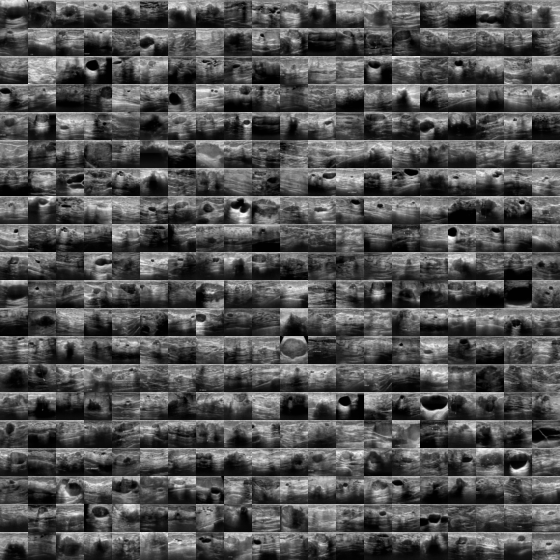

In [35]:
# montage
train_dataset.montage(length=20)

## Then, we define a simple model for illustration, object function and optimizer that we use to classify.

In [68]:
from AttentionMap.AttentionMap import GridAttentionBlock

class Model(nn.Module):
    def __init__(self, input_size, in_channels, n_classes, attention=True, normalize_attn=True) -> None:
        super(Model, self).__init__()
        self.l1 = nn.Sequential(*[
            nn.Conv2d(in_channels, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.SELU(),
            nn.MaxPool2d(2),
        ])

        self.l2 = nn.Sequential(*[
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.SELU(),
            nn.MaxPool2d(2),
        ])

        self.l3 = nn.Sequential(*[
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.SELU(),
            nn.MaxPool2d(2),
        ])


        self.g_descriptor = nn.Sequential(*[
            nn.Conv2d(256, 256, kernel_size=3, padding=1)
        ])

        self.attention = attention
        if attention:
            self.attn_l1 = GridAttentionBlock(64, 256, 32, 2**2, normalize=normalize_attn)
            self.attn_l2 = GridAttentionBlock(128, 256, 32, 2**1, normalize=normalize_attn)
            self.attn_l3 = GridAttentionBlock(256, 256, 32, 2**0, normalize=normalize_attn)
            self.classify = nn.Linear(64+128+256, n_classes, bias=True)
        else:
            self.classify = nn.Linear(256, n_classes, bias=True)

        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.Conv2d)):
                torch.nn.init.kaiming_uniform_(module.weight)

    def forward(self, x) -> torch.Tensor:

        l1_out = self.l1(x)
        l2_out = self.l2(l1_out)
        l3_out = self.l3(l2_out)
        g = self.g_descriptor(l3_out)

        if self.attention:
            c1, g1 = self.attn_l1(l1_out, g)
            c2, g2 = self.attn_l2(l2_out, g)
            c3, g3 = self.attn_l3(l3_out, g)

            g = torch.cat((g1,g2,g3), dim=1) # batch_sizexC
            # classification layer
            y_hat = self.classify(g) # batch_sizexnum_classes
        else:
            c1, c2, c3 = None, None, None
            y_hat = self.classify(g)

        return (y_hat, c1, c2, c3)

In [69]:
model = Model(32, 1, 2, normalize_attn=True)
pred, c1, c2, c3 = model(x)
print(pred.shape)

torch.Size([32, 2])


In [70]:
from torch.utils.tensorboard import SummaryWriter
import torchvision.utils as utils
from AttentionMap.utils import visualize_attention

model = Model(32, 1, 2, normalize_attn=True)
model.train()

optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
# criterion = nn.BCEWithLogitsLoss()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

tb_writer = SummaryWriter('log/MedMNIST')
running_avg_accuracy = 0
step = 0

# TMP
log_images = True

for epoch in range(NUM_EPOCHS):
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        # log scalars
        images_disp = []
        for i, data in enumerate(test_loader, 0):
                images_test, labels_test = data
                images_test, labels_test = images_test.to(device), labels_test.to(device).flatten()
                pred_test, c1, c2, c3 = model(images_test)
                predict = torch.argmax(pred_test, 1)
                total += labels_test.size(0)
                correct += torch.eq(predict, labels_test).sum().double().item()
                
        tb_writer.add_scalar('test/accuracy', correct/total, epoch)

        n_rows=2
        activation = 'softmax'
        # C1
        scale_factor = 2**1
        vis = visualize_attention(n_rows, images_test[:4], c1[:4], scale_factor, activation=activation)
        tb_writer.add_image('Attention/C1', vis, epoch)

        # C2
        scale_factor = 2**2
        vis = visualize_attention(n_rows, images_test[:4], c2[:4], scale_factor, activation=activation)
        tb_writer.add_image('Attention/C2', vis, epoch)

        # C3
        scale_factor = 2**3
        vis = visualize_attention(n_rows, images_test[:4], c3[:4], scale_factor, activation=activation)
        tb_writer.add_image('Attention/C3', vis, epoch)

    model.train()
    for idx, (inputs, targets) in enumerate(train_loader):
        optimizer.zero_grad()

        inputs = inputs.to(device)
        targets = targets.to(device).flatten()
        pred, __, __, __ = model(inputs)

        loss = criterion(pred, targets.flatten())
        loss.backward()
        optimizer.step()

        if idx % 10:
            model.eval()
            pred, __, __, __ = model(inputs)
            predict = torch.argmax(pred, 1)
            total = targets.size(0)
            correct = torch.eq(predict, targets).sum().double().item()
            accuracy = correct / total
            running_avg_accuracy = 0.9*running_avg_accuracy + 0.1*accuracy
            tb_writer.add_scalar('train/loss', loss.item(), step)
            tb_writer.add_scalar('train/accuracy', accuracy, step)
            tb_writer.add_scalar('train/running_avg_accuracy', running_avg_accuracy, step)
            step += 1

In [ ]:
# class Net(nn.Module):
#     def __init__(self, in_channels, num_classes):
#         super(Net, self).__init__()

#         self.layer1 = nn.Sequential(
#             nn.Conv2d(in_channels, 16, kernel_size=3),
#             nn.BatchNorm2d(16),
#             nn.ReLU())

#         self.layer2 = nn.Sequential(
#             nn.Conv2d(16, 16, kernel_size=3),
#             nn.BatchNorm2d(16),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2))

#         self.layer3 = nn.Sequential(
#             nn.Conv2d(16, 64, kernel_size=3),
#             nn.BatchNorm2d(64),
#             nn.ReLU())
        
#         self.layer4 = nn.Sequential(
#             nn.Conv2d(64, 64, kernel_size=3),
#             nn.BatchNorm2d(64),
#             nn.ReLU())

#         self.layer5 = nn.Sequential(
#             nn.Conv2d(64, 64, kernel_size=3, padding=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2))

#         self.fc = nn.Sequential(
#             nn.Linear(64 * 4 * 4, 128),
#             nn.ReLU(),
#             nn.Linear(128, 128),
#             nn.ReLU(),
#             nn.Linear(128, num_classes))

#     def forward(self, x):
#         x = self.layer1(x)
#         x = self.layer2(x)
#         x = self.layer3(x)
#         x = self.layer4(x)
#         x = self.layer5(x)
#         x = x.view(x.size(0), -1)
#         x = self.fc(x)
#         return x

# model = Net(in_channels=n_channels, num_classes=n_classes)

# # define loss function and optimizer
# if task == "multi-label, binary-class":
#     criterion = nn.BCEWithLogitsLoss()
# else:
#     criterion = nn.CrossEntropyLoss()
    
# optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [ ]:
# train

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0
    
    model.train()
    for inputs, targets in tqdm(train_loader):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs)
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()

In [ ]:
# evaluation

def test(split):
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])
    
    data_loader = train_loader_at_eval if split == 'train' else test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()
        
        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)
    
        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))

        
print('==> Evaluating ...')
test('train')
test('test')